In [1]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import dnnlib
import legacy
from torchvision.utils import save_image
from torchvision import models

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

network_pkl = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-car-config-e.pkl"
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
G.eval()
for param in G.parameters():
    param.requires_grad = False

Setting up PyTorch plugin "bias_act_plugin"... 

/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


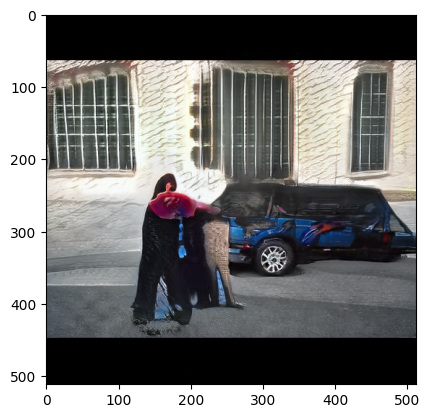

In [2]:
z = torch.randn(1, 512, device=device)
w = G.mapping(z, None)
generated_image = G.synthesis(w, noise_mode='const')
img = (generated_image.clamp(-1, 1) + 1) / 2 * 255
img = img.permute(0, 2, 3, 1).to(torch.uint8)[0].cpu().numpy()

plt.imshow(img)
plt.show()

# Generating images

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

# Ensure the folder exists
output_folder = "../styleGanImages"
os.makedirs(output_folder, exist_ok=True)

# Optionally, if you want to see a progress bar, you can use tqdm:
# from tqdm import tqdm

num_images = 10000
batch_size = 32  # Adjust based on your GPU memory
num_batches = num_images // batch_size

start_time = time.time()
latent_vectors = []
images = []

with torch.no_grad():
    for batch_idx in range(num_batches):
        # Generate batch of latent vectors
        z = torch.randn(batch_size, 512, device=device)
        latent_vectors.append(z)
        # Mapping network
        w = G.mapping(z, None)
        # Synthesis network to generate images
        generated_images = G.synthesis(w, noise_mode='const')
        images.append(generated_images)

        # Process and save each image in the batch
        # for i in range(batch_size):
        #     img = (generated_images[i].clamp(-1, 1) + 1) / 2 * 255
        #     img = img.permute(1, 2, 0).to(torch.uint8).cpu().numpy()
        #     filename = os.path.join(output_folder, f"image_{batch_idx * batch_size + i:05d}.png")
        #     plt.imsave(filename, img)

        # Optionally print progress every 100 batches
        if (batch_idx + 1) % 1000 == 0:
            print(f"{(batch_idx + 1) * batch_size} images generated.")
            latent_vectors = np.array(latent_vectors)
            latent_vectors_file = "latent_vectors.npy"
            np.save(latent_vectors_file, latent_vectors)
            print(f"Latent vectors saved to {latent_vectors_file}")
            latent_vectors = list(latent_vectors)

end_time = time.time()
total_time = end_time - start_time
avg_time = total_time / num_images

print(f"Finished generating {num_images} images.")
print(f"Time taken: {total_time} seconds")
print(f"Average time per image: {avg_time} seconds")


# Log the performance metrics
with open("log.txt", "w") as f:
    f.write(f"Time taken to generate {num_images} images: {total_time} seconds\n")
    f.write(f"Average time per image: {avg_time} seconds\n")
    f.write(f"Total images generated: {num_images}\n")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 2 has a total capacity of 15.75 GiB of which 300.06 MiB is free. Including non-PyTorch memory, this process has 15.07 GiB memory in use. Of the allocated memory 11.17 GiB is allocated by PyTorch, and 2.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
import numpy as np

# Save latent vectors to a file         Do not uncomment unliess you want to save the latent vectors othewise if it is overwritten then all wiil be lost
# np.save("latent_vectors.npy", np.array(latent_vectors))
# print("Latent vectors saved to latent_vectors.npy")

# Load the latent vectors from the .npy file
latent_vectors = np.load("latent_vectors.npy", allow_pickle=True)
print("Latent vectors loaded:", latent_vectors.shape)


Latent vectors loaded: (10000, 1, 512)


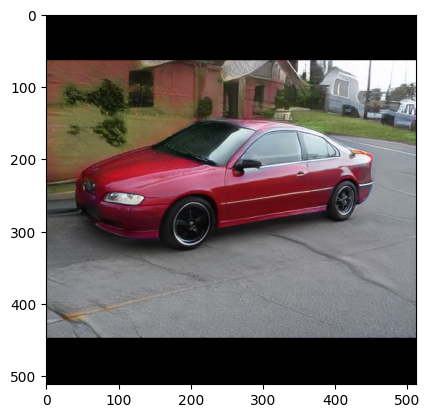

In [10]:
def genImg(z):
    z = torch.tensor(z, device=device)
    z = z.view(1, 512)
    w = G.mapping(z, None)
    generated_image = G.synthesis(w, noise_mode='const')
    img = (generated_image.clamp(-1, 1) + 1) / 2 * 255
    img = img.permute(0, 2, 3, 1).to(torch.uint8)[0].cpu().numpy()
    return img

plt.imshow(img)
plt.show()

In [ ]:
import torch
from PIL import Image
import open_clip

# Create the model, the associated preprocessing transforms, and the tokenizer.
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', 
    pretrained='laion2b_s34b_b79k'
)
model.eval()  # Set the model to evaluation mode (important for layers like BatchNorm)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# Load and preprocess the image.
image = preprocess(Image.open("../styleGanImages/image_00001.png")).unsqueeze(0)

# Tokenize the text labels.
text = tokenizer(["a diagram", "a dog", "a cat"])

# Use autocast for automatic mixed precision on CUDA if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
image = image.to(device)
text = text.to(device)

with torch.no_grad(), torch.autocast(device if device == "cuda" else "cpu"):
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

print(image_features.shape)
print(image_features)


torch.Size([1, 512])
tensor([[-1.3133e-03, -1.1439e-01, -5.2819e-02,  3.9302e-02,  4.1756e-02,
          4.1189e-02, -1.7804e-02,  1.9244e-02,  1.1486e-02,  4.5417e-02,
          8.7697e-03, -1.3166e-02,  3.3063e-04, -2.0773e-02,  4.6838e-02,
         -1.0155e-02, -1.1160e-01,  4.3392e-02,  1.8096e-02,  4.4880e-02,
         -5.8012e-03, -2.3256e-02,  5.1537e-02,  1.0317e-02, -3.7269e-02,
          5.7156e-02,  2.0249e-02, -5.1068e-02,  4.0208e-03,  5.8820e-02,
          7.0561e-02, -1.8649e-02, -5.9091e-03, -4.7415e-03,  1.9289e-02,
         -1.8654e-03,  4.4676e-02, -5.2358e-02,  3.0242e-02, -2.3092e-02,
          4.4563e-03,  2.9100e-02, -4.3212e-02,  5.6606e-02, -2.8157e-03,
         -2.2017e-02,  6.2134e-02,  4.5094e-03, -1.8721e-03,  5.5000e-03,
         -1.5167e-02,  8.4626e-02,  6.6188e-02, -1.4648e-02, -1.2676e-01,
         -8.9668e-02, -1.3835e-03,  7.2558e-04, -8.0830e-03,  2.6709e-02,
          7.5813e-02, -6.5981e-02, -9.9296e-04, -8.8400e-02, -8.0733e-03,
         -2.4884e

# Extracting features using ViT

In [ ]:
image_features = []
images = 10000
for i in range(images):
    # Load and preprocess the image.
    image = preprocess(Image.open(f"../styleGanImages/image_{i:05d}.png")).unsqueeze(0)

    # Use autocast for automatic mixed precision on CUDA if available.
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = image.to(device)

    with torch.no_grad(), torch.autocast(device if device == "cuda" else "cpu"):
        image_features.append(model.encode_image(image))
        image_features[-1] /= image_features[-1].norm(dim=-1, keepdim=True)
    if(i%1000 == 0):
        print(f"Processed {i} images.")

Processed 0 num_images.


In [27]:
temp = []
for vec in image_features:
    vec = vec.cpu().numpy()
    temp.append(vec)
print("Finished generating image features.")
image_features = np.array(temp)
del temp

Finished generating image features.


In [2]:
import numpy as np

# Save latent vectors to a file         Do not uncomment unliess you want to save the latent vectors othewise if it is overwritten then all wiil be lost
# np.save("image_features.npy", np.array(image_features))
# print("Latent vectors saved to image_features.npy")

# Load the latent vectors from the .npy file
image_features = np.load("image_features.npy", allow_pickle=True)
print("Latent vectors loaded:", image_features.shape)


Latent vectors loaded: (10000, 1, 512)


In [29]:
concated = np.concatenate((latent_vectors, image_features), axis=1)
print("Concatenated latent vectors and image features:", concated.shape)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

# Kmeans on image features

Vectors shape: (9984, 512)


/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


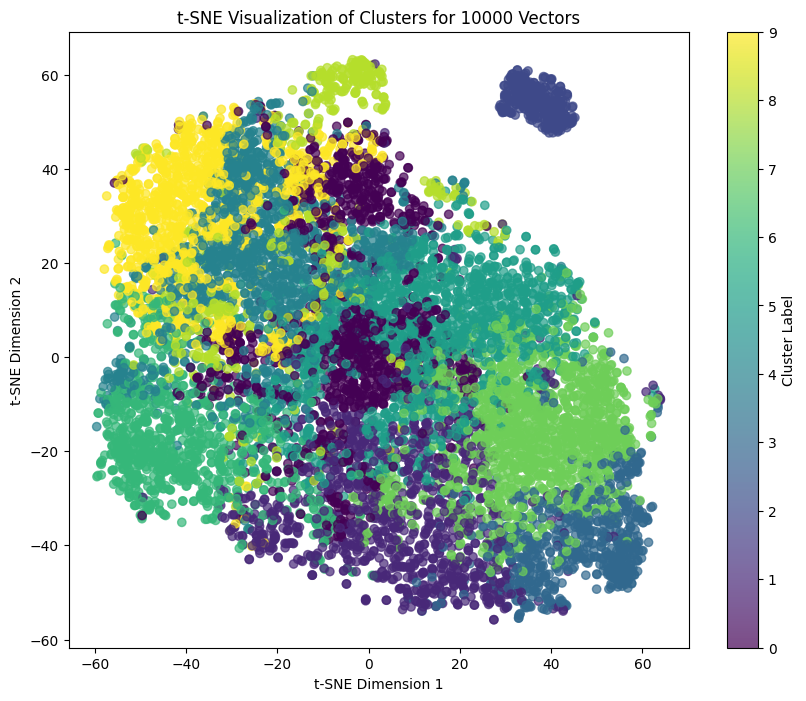

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Assume you have a NumPy array 'vectors' of shape (10000, 512)
# For demonstration, here's how you might generate random data:
vectors = image_features.squeeze()
print("Vectors shape:", vectors.shape)

# Dimensionality reduction with PCA (reduce to 50 dimensions)
pca = PCA(n_components=50)
# vectors_pca = pca.fit_transform(vectors)
vectors_pca = vectors

# Further reduce dimensions to 2 for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
vectors_2d = tsne.fit_transform(vectors_pca)

# Clustering using KMeans (set number of clusters as needed, here n_clusters = 10)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

# Plotting the t-SNE results with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    vectors_2d[:, 0], vectors_2d[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.7
)
plt.title("t-SNE Visualization of Clusters for 10000 Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster Label")
plt.show()


In [79]:
vectors_by_label = {label: latent_vectors[cluster_labels == label] for label in range(n_clusters)}


In [80]:
print("Vectors by label:")
for label, vecs in vectors_by_label.items():
    print(f"Label {label}: {vecs.shape[0]} vectors")
    # Optionally, you can visualize or save these vectors
    # For example, you could save them to a file or plot them
    # np.save(f"vectors_label_{label}.npy", vecs)

Vectors by label:
Label 0: 1172 vectors
Label 1: 1085 vectors
Label 2: 312 vectors
Label 3: 690 vectors
Label 4: 1273 vectors
Label 5: 1435 vectors
Label 6: 958 vectors
Label 7: 1472 vectors
Label 8: 505 vectors
Label 9: 1082 vectors


Generated 5 images for cluster 0 ******************************


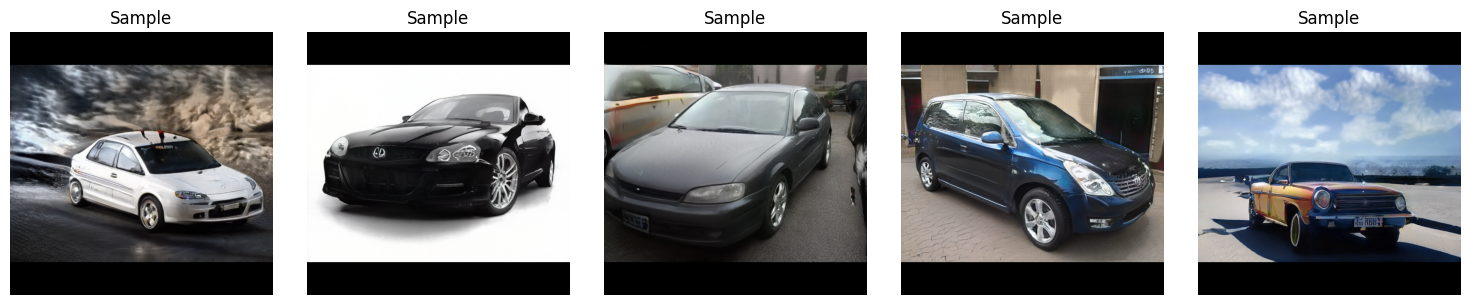

Generated 5 images for cluster 1 ******************************


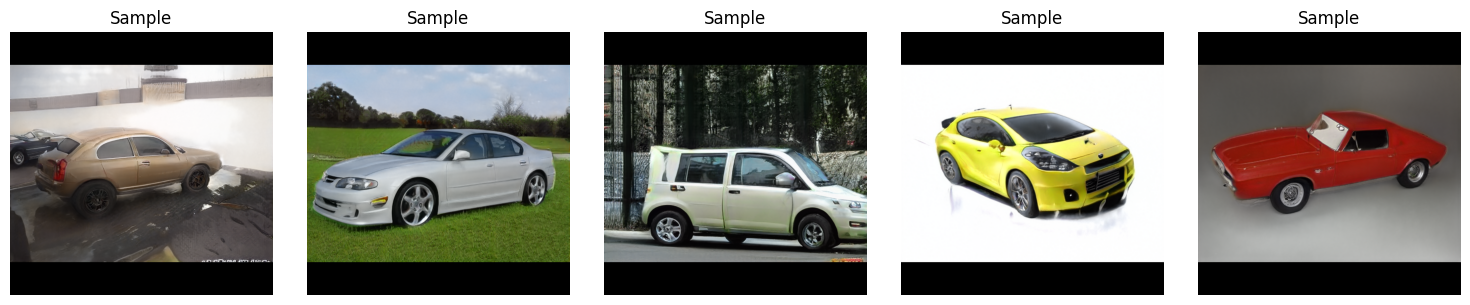

Generated 5 images for cluster 2 ******************************


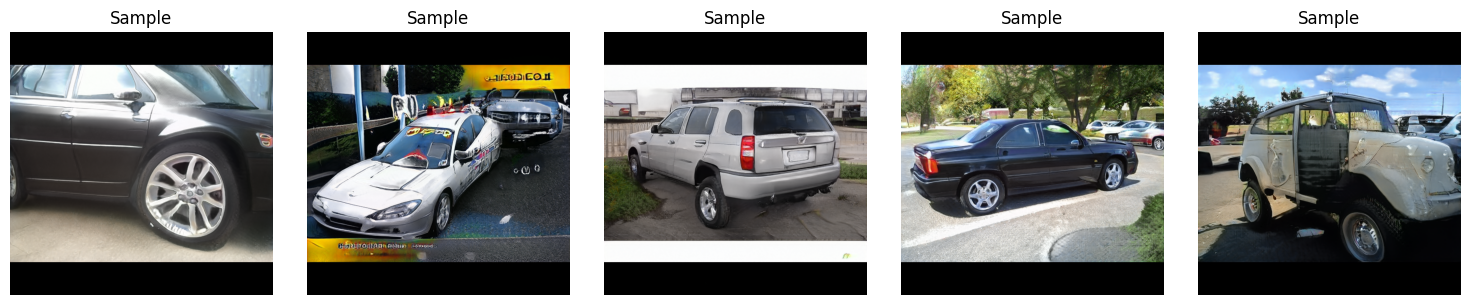

Generated 5 images for cluster 3 ******************************


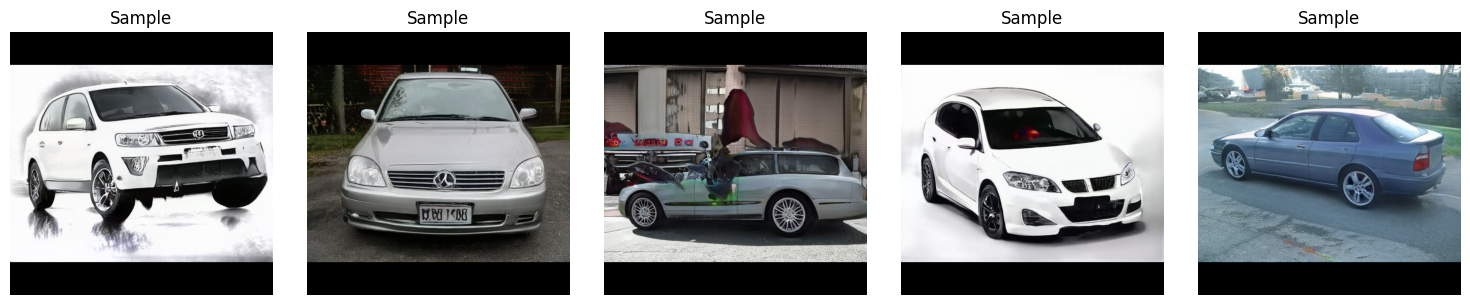

Generated 5 images for cluster 4 ******************************


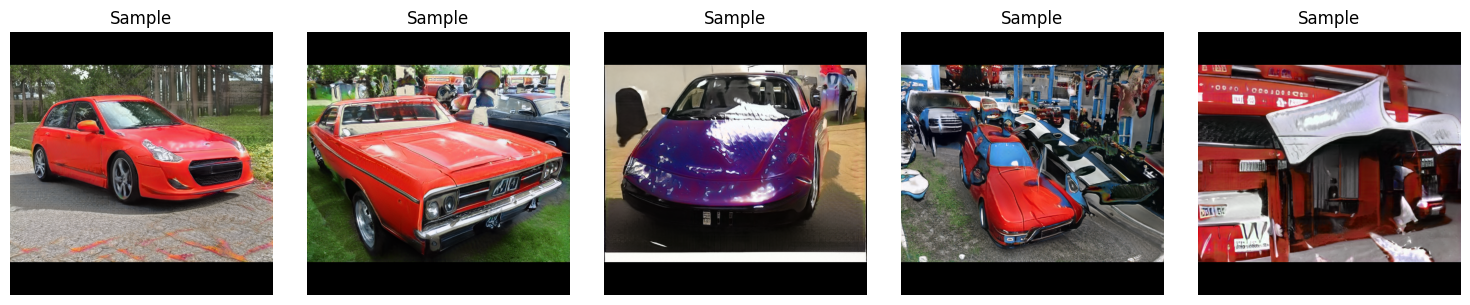

Generated 5 images for cluster 5 ******************************


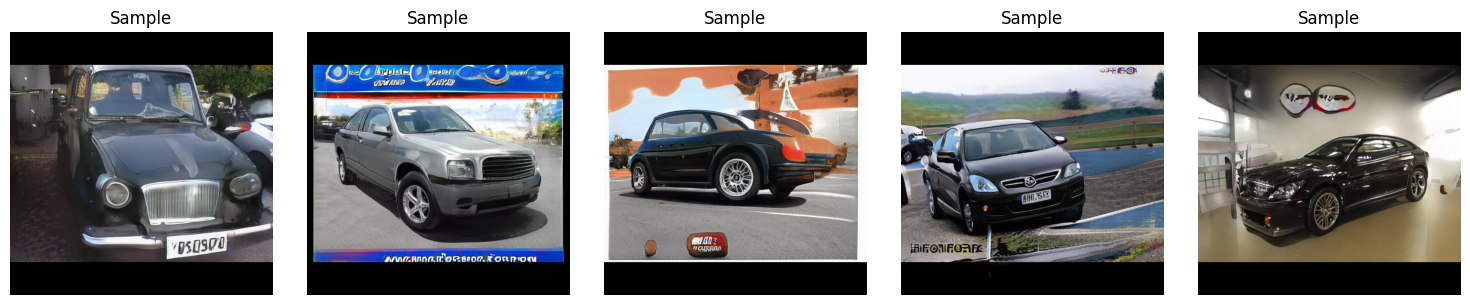

Generated 5 images for cluster 6 ******************************


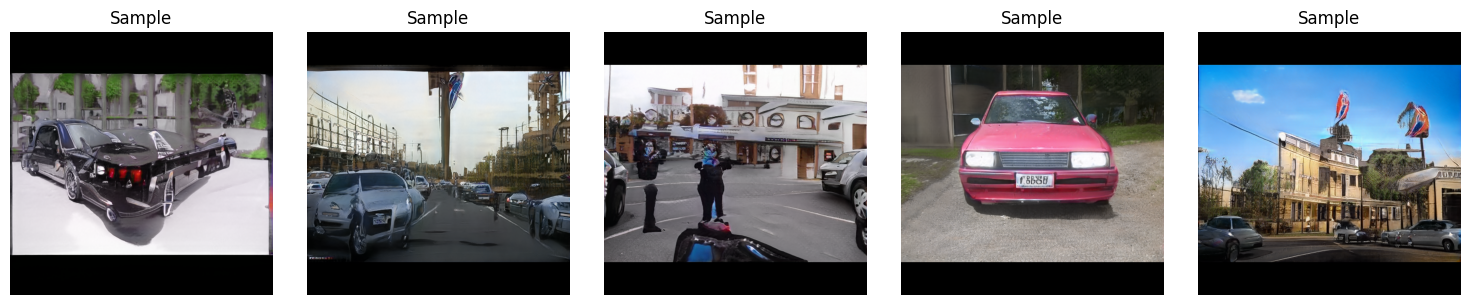

Generated 5 images for cluster 7 ******************************


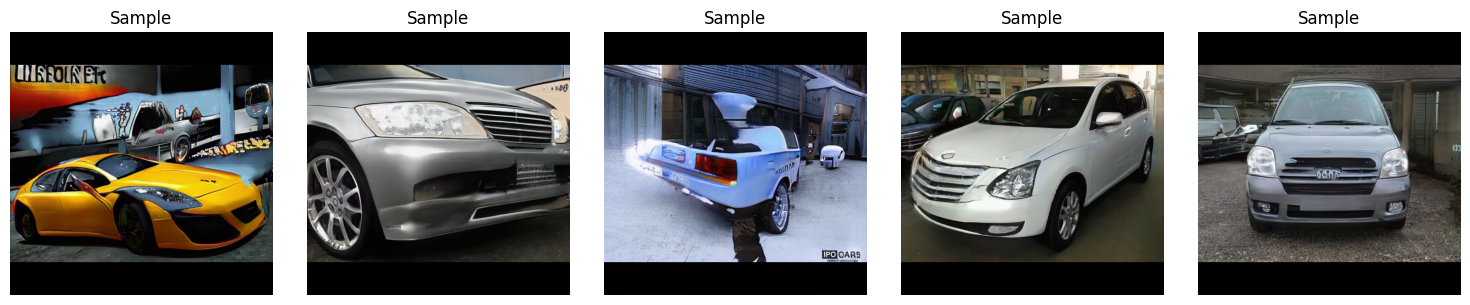

Generated 5 images for cluster 8 ******************************


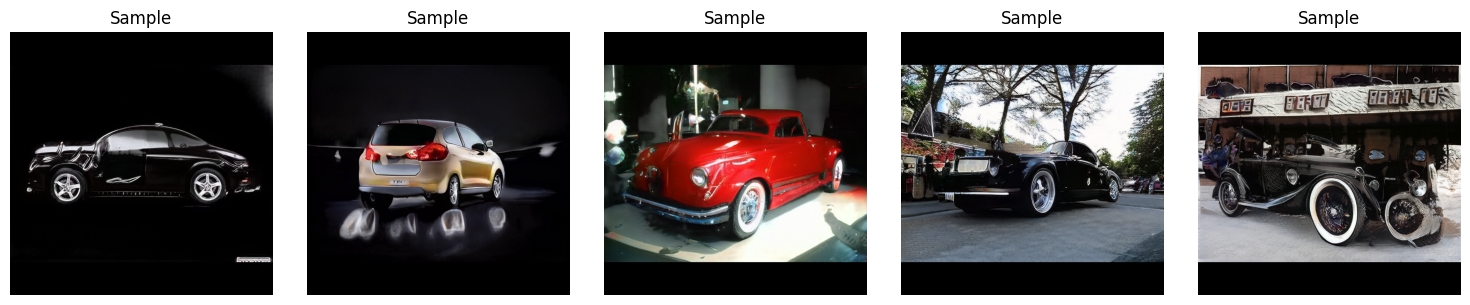

Generated 5 images for cluster 9 ******************************


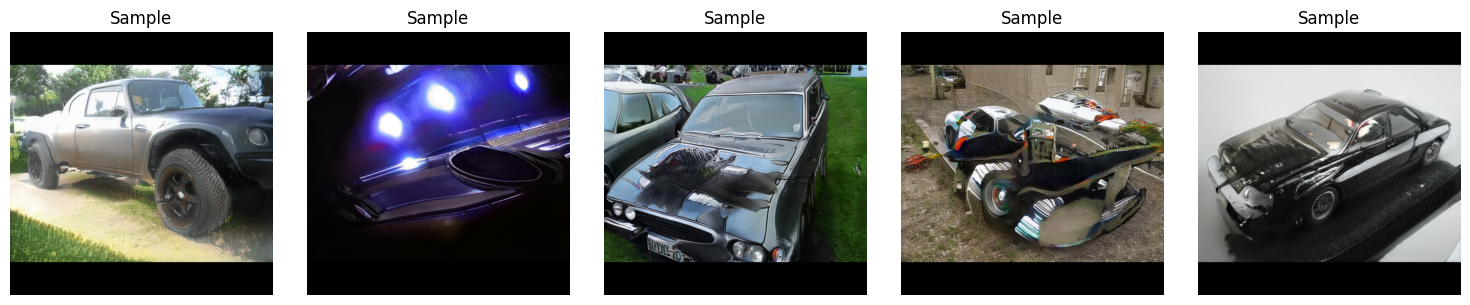

In [367]:
import matplotlib.pyplot as plt

for cluster_label, i in vectors_by_label.items():
    print(f"Generated 5 images for cluster {cluster_label}", '*' * 30)
    
    # Create a figure with 1 row and 5 columns of subplots
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    for ax in axes:
        # Select a random latent vector from the current cluster
        z = i[np.random.randint(0, len(i))]
        
        # Generate an image from the latent vector
        img = genImg(z)
        
        # Display the image on the subplot
        ax.imshow(img)
        ax.axis('off')  # Hide axis ticks
        ax.set_title("Sample")
    
    plt.tight_layout()
    plt.show()



# Using clusters to train a gan on latent space

In [364]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the device; if cuda:0 is available, use it.
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Define a simple generator network
class SimpleGenerator(nn.Module):
    def __init__(self, input_dim=512, output_dim=512, hidden_dim=1024):
        super(SimpleGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Tanh squashes the output to [-1, 1]
        )
    
    def forward(self, x):
        return self.model(x)

# Instantiate the generator and move it to cuda:0
generator = SimpleGenerator().to(device)

# Define an optimizer and a loss function.
optimizer = optim.Adam(generator.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Assume vectors_by_label[3] is already on device or move it accordingly.
# For example, if not already on GPU, move it:
target = torch.tensor(vectors_by_label[8]).to(device)  # Batch size = 64
print("Target shape:", target.shape)

# Training loop
num_epochs = 5
batch_size = 64

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Create random noise input and move it to device (batch_size, 512)
    noise = torch.randn(batch_size, 512, device=device)
    
    # Generate output vector
    output = generator(noise)
    
    # Compute loss (comparing against our dummy target)
    loss = criterion(output, target)
    
    # Backpropagation and weight update
    loss.backward()
    optimizer.step()
    
    # Print loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Target shape: torch.Size([505, 512])


/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([505, 512])) that is different to the input size (torch.Size([64, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (505) at non-singleton dimension 0

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:2! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

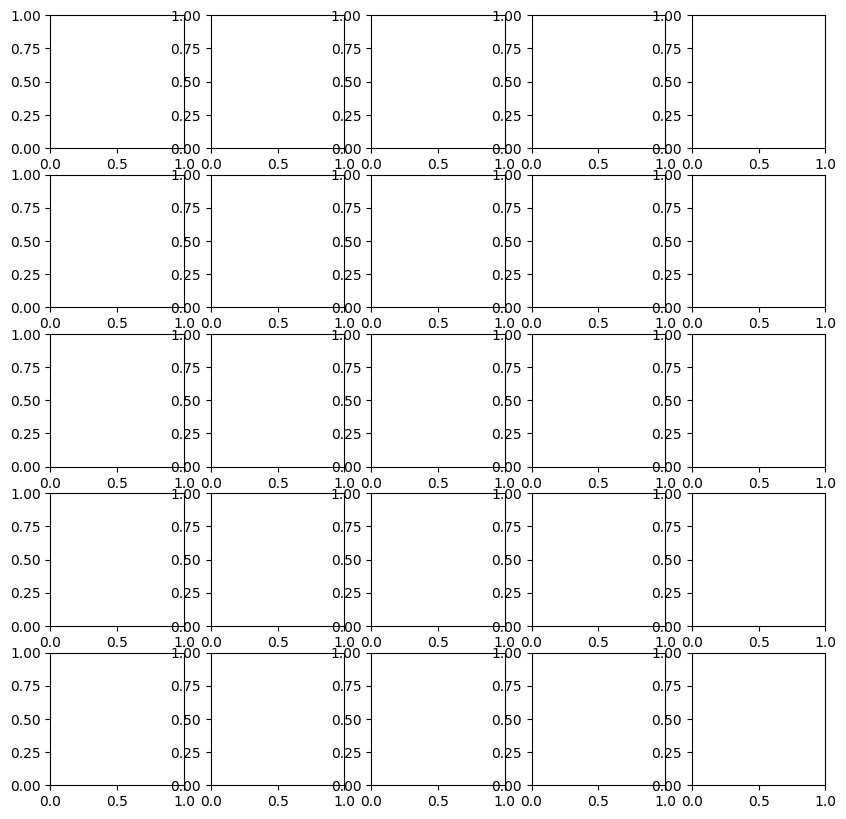

In [366]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_image(generator, G, device):
    z = torch.randn(1, 512, device=device)
    z = generator(z).to(device)
    w = G.mapping(z, None)
    generated_image = G.synthesis(w, noise_mode='const')
    img = (generated_image.clamp(-1, 1) + 1) / 2 * 255
    img = img.permute(0, 2, 3, 1).to(torch.uint8)[0].cpu().numpy()
    return img

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        img = generate_image(generator, G, device)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [288]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the device; if cuda:0 is available, use it.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024, latent_dim=256):
        super(VAE, self).__init__()
        # Encoder layers: from input to hidden, then to latent parameters
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Log variance
        
        # Decoder layers: from latent to hidden, then to output
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()  # Squashes output to [-1, 1]

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: sample epsilon from N(0,1) and scale by std
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        # h = z
        x_recon = self.tanh(self.fc3(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Instantiate the VAE and move it to device
vae = VAE().to(device)

# Define the optimizer and the reconstruction loss function (MSE)
optimizer = optim.Adam(vae.parameters(), lr=0.001,weight_decay=1e-2)
reconstruction_loss_fn = nn.MSELoss()

def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (how close the output is to the input)
    recon_loss = reconstruction_loss_fn(recon_x, x)
    # KL divergence loss ensures the latent space approximates a standard normal distribution
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalize KL divergence over the batch
    kl_loss = kl_loss / x.size(0)
    return recon_loss + kl_loss


target = torch.tensor(vectors_by_label[5]).to(device)  # Expected shape: (batch_size, 512)

# Training loop
num_epochs = 10
batch_size = 1

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # In a typical VAE, you train on your data. Here we assume 'target' is your batch of data.
    # If 'target' does not have the batch dimension, you may need to adjust or replicate it.
    recon, mu, logvar = vae(target)
    
    loss = vae_loss(recon, target, mu, logvar)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 11.8794
Epoch 2/10, Loss: 10.1984
Epoch 3/10, Loss: 8.0235
Epoch 4/10, Loss: 6.8707
Epoch 5/10, Loss: 6.1533
Epoch 6/10, Loss: 5.1820
Epoch 7/10, Loss: 4.2088
Epoch 8/10, Loss: 3.5595
Epoch 9/10, Loss: 3.2499
Epoch 10/10, Loss: 3.0885


/tmp/ipykernel_1897760/3166352879.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, device=device)
/tmp/ipykernel_1897760/3166352879.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, device=device)
/tmp/ipykernel_1897760/3166352879.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, device=device)
/tmp/ipykernel_1897760/3166352879.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

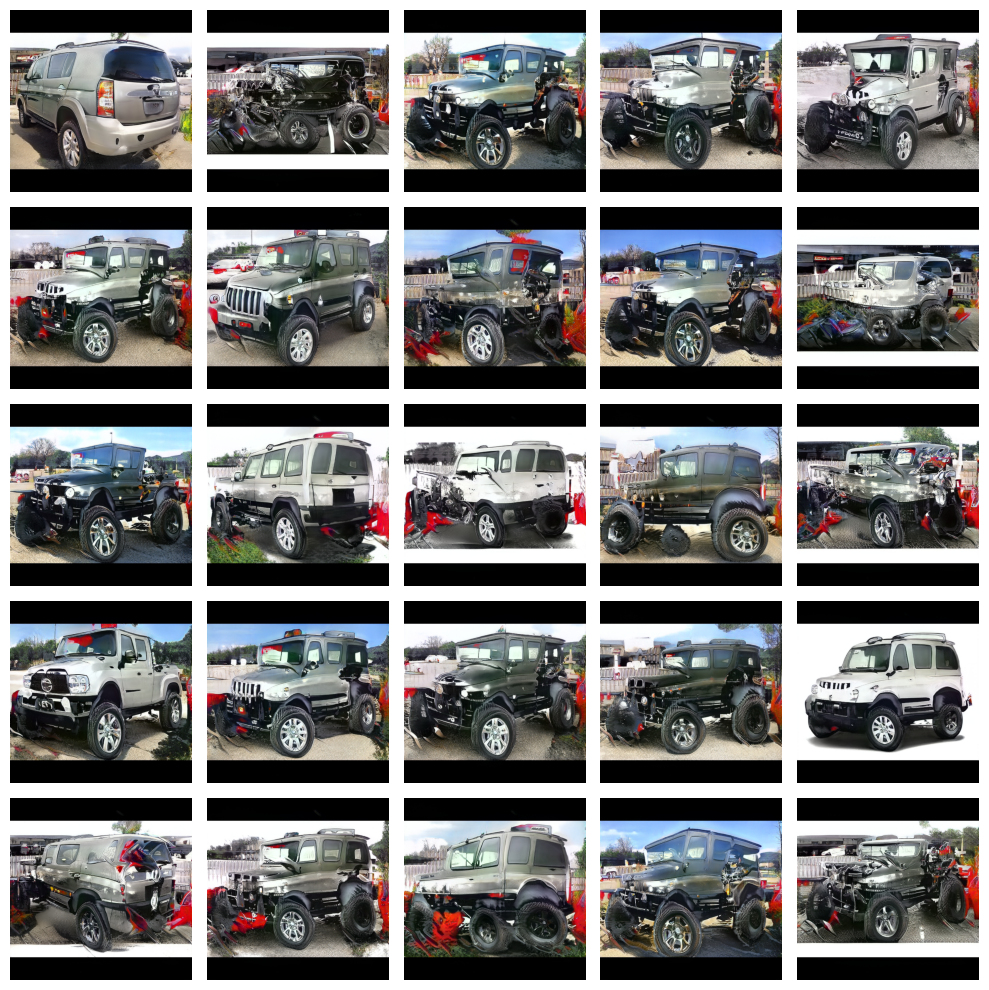

In [294]:
import torch
import matplotlib.pyplot as plt

latent_dim = 256
num_images = 25

# Create a 5x5 subplot grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_images):
    # Sample a random latent vector and decode it with the VAE
    z = torch.randn(1, latent_dim, device=device)
    decoded = vae.decode(z)
    
    # Generate an image using your genImg function (make sure genImg expects the right shape)
    img = genImg(decoded.to(device).squeeze())
    
    # Display the image in the grid
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
